In [ ]:
!pip install flair

In [ ]:
# !pip install ipywidgets widgetsnbextension pandas-profiling
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import math
import pickle
import spacy
import nltk
import numpy as np
import gzip
import glob
import pandas as pd
from pprint import pprint

#spacy
import spacy
from nltk.corpus import stopwords

from ipywidgets import FloatProgress


# #Gensim
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel
# from gensim.models.wrappers import LdaMallet

# #vis
# # import pyLDAvis as pyLDAvis
# # import pyLDAvis.gensim_models as gensimvis
# # import matplotlib.pyplot as plt
# # %matplotlib inline

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
#ldamallet=pickle.load(open("ldamallet.pkl", "rb"))
#tm_results = ldamallet[corpus]

In [ ]:
jumia_product_url = input('Please enter the cellphone product URL')

response = requests.get(jumia_product_url)
# Check successful response
if response.status_code != 200:
    raise Exception('Failed to load page {}'.format(jumia_product_url))
# Parse using BeautifulSoup
product_doc = BeautifulSoup(response.text, 'html.parser')

Please enter the cellphone product URLhttps://www.jumia.co.ke/camon-18-6.8-inch-128gb4gb-ram-48-mp-battery-5000-ceramic-white-tecno-mpg354300.html


In [ ]:
review_page = product_doc.find('a',{'class':'-plxs'})
base_url = 'https://www.jumia.co.ke'
review_url = base_url + review_page.get('href','')

response = requests.get(review_url)
# Check successful response
if response.status_code != 200:
    raise Exception('Failed to load page {}'.format(review_url))
# Parse using BeautifulSoup
review_doc = BeautifulSoup(response.text, 'html.parser')

In [ ]:
# Name of the phone and price
price_tag = review_doc.find_all('span', {'class':'-b -ltr -tal -fs24'})
print(price_tag)

name_tag= review_doc.find('a', {'class':"_more"})
print(name_tag)


# Find the count of reviews of the given product

total_counts = review_doc.find_all('h2',{'class':'-fs14'})
review_count = total_counts[1].text
lst = review_count.split()
refined = lst[2].replace("(","")
f_count = refined.replace(")","")
final_count = int(f_count)
total_review_pages = math.ceil(final_count / 10)

# Find URL of each of the pages
current_page = 1
review_url =  []
while current_page <= total_review_pages :
  review_url.append(base_url + review_page.get('href','') + '?page=' + str(current_page))
  current_page += 1
    

descs = []
for url in review_url:
  response = requests.get(url)
  review_doc = BeautifulSoup(response.text, 'html.parser')
  desc_tags = review_doc.find_all('p',{'class':'-pvs'})
  for tag in desc_tags:
    descs.append(tag.text)

print('Extracted number of reviews is ' + str(len(descs)))
jumia_df = pd.DataFrame(descs,columns =['reviewText'])
jumia_df

[]
<a class="_more -fs12" href="/sp-privacy/" rel="noopener" target="_blank">Privacy and Cookie notice</a>
Extracted number of reviews is 18


,reviewText
0,Great buy!
1,It is just dope
2,the \n\nphone gets really hot so fast and lose...
3,Excellent battery and fast charging
4,everything is damn fine.
5,"The phone is amazing, especially the dark mode..."
6,Battery iko chonjo kabisa
7,I received it on time and the package was well...
8,Very good quality
9,Phone works perfectly.


In [ ]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

jumia_df['remove_lower_punct'] = jumia_df['reviewText'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()

display(jumia_df.head(10))

,reviewText,remove_lower_punct
0,Great buy!,great buy
1,It is just dope,it is just dope
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...
3,Excellent battery and fast charging,excellent battery and fast charging
4,everything is damn fine.,everything is damn fine
5,"The phone is amazing, especially the dark mode...",the phone is amazing especially the dark mode ...
6,Battery iko chonjo kabisa,battery iko chonjo kabisa
7,I received it on time and the package was well...,i received it on time and the package was well...
8,Very good quality,very good quality
9,Phone works perfectly.,phone works perfectly


In [ ]:
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in jumia_df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
jumia_df['sentiment'] = sentiment_label_list
jumia_df['sentiment score'] = sentiment_score_list

display(jumia_df)

,reviewText,remove_lower_punct,sentiment,sentiment score
0,Great buy!,great buy,Positive,0.6249
1,It is just dope,it is just dope,Neutral,0.0000
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...,Positive,0.3892
3,Excellent battery and fast charging,excellent battery and fast charging,Positive,0.5719
4,everything is damn fine.,everything is damn fine,Negative,-0.2263
5,"The phone is amazing, especially the dark mode...",the phone is amazing especially the dark mode ...,Positive,0.5859
6,Battery iko chonjo kabisa,battery iko chonjo kabisa,Neutral,0.0000
7,I received it on time and the package was well...,i received it on time and the package was well...,Positive,0.8168
8,Very good quality,very good quality,Positive,0.4927
9,Phone works perfectly.,phone works perfectly,Positive,0.6369


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# tokenise string

jumia_df['tokenise'] = jumia_df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1)

display(jumia_df.head(10))

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise
0,Great buy!,great buy,Positive,0.6249,"[great, buy]"
1,It is just dope,it is just dope,Neutral,0.0000,"[it, is, just, dope]"
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...,Positive,0.3892,"[the, phone, gets, really, hot, so, fast, and,..."
3,Excellent battery and fast charging,excellent battery and fast charging,Positive,0.5719,"[excellent, battery, and, fast, charging]"
4,everything is damn fine.,everything is damn fine,Negative,-0.2263,"[everything, is, damn, fine]"
5,"The phone is amazing, especially the dark mode...",the phone is amazing especially the dark mode ...,Positive,0.5859,"[the, phone, is, amazing, especially, the, dar..."
6,Battery iko chonjo kabisa,battery iko chonjo kabisa,Neutral,0.0000,"[battery, iko, chonjo, kabisa]"
7,I received it on time and the package was well...,i received it on time and the package was well...,Positive,0.8168,"[i, received, it, on, time, and, the, package,..."
8,Very good quality,very good quality,Positive,0.4927,"[very, good, quality]"
9,Phone works perfectly.,phone works perfectly,Positive,0.6369,"[phone, works, perfectly]"


In [ ]:
# initiate stopwords from nltk

stop_words = stopwords.words('english')

# add additional missing terms

#stop_words.extend(stop_words_list) 

# remove stopwords

jumia_df['remove_stopwords'] = jumia_df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])

display(jumia_df.head(10))

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords
0,Great buy!,great buy,Positive,0.6249,"[great, buy]","[great, buy]"
1,It is just dope,it is just dope,Neutral,0.0000,"[it, is, just, dope]",[dope]
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...,Positive,0.3892,"[the, phone, gets, really, hot, so, fast, and,...","[phone, gets, really, hot, fast, loses, batter..."
3,Excellent battery and fast charging,excellent battery and fast charging,Positive,0.5719,"[excellent, battery, and, fast, charging]","[excellent, battery, fast, charging]"
4,everything is damn fine.,everything is damn fine,Negative,-0.2263,"[everything, is, damn, fine]","[everything, damn, fine]"
5,"The phone is amazing, especially the dark mode...",the phone is amazing especially the dark mode ...,Positive,0.5859,"[the, phone, is, amazing, especially, the, dar...","[phone, amazing, especially, dark, mode, also,..."
6,Battery iko chonjo kabisa,battery iko chonjo kabisa,Neutral,0.0000,"[battery, iko, chonjo, kabisa]","[battery, iko, chonjo, kabisa]"
7,I received it on time and the package was well...,i received it on time and the package was well...,Positive,0.8168,"[i, received, it, on, time, and, the, package,...","[received, time, package, well, packed, phone,..."
8,Very good quality,very good quality,Positive,0.4927,"[very, good, quality]","[good, quality]"
9,Phone works perfectly.,phone works perfectly,Positive,0.6369,"[phone, works, perfectly]","[phone, works, perfectly]"


In [ ]:
from nltk.stem import WordNetLemmatizer
# initiate nltk lemmatiser

wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

jumia_df['lemmatise'] = jumia_df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

display(jumia_df.head(10))

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise
0,Great buy!,great buy,Positive,0.6249,"[great, buy]","[great, buy]","[great, buy]"
1,It is just dope,it is just dope,Neutral,0.0000,"[it, is, just, dope]",[dope],[dope]
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...,Positive,0.3892,"[the, phone, gets, really, hot, so, fast, and,...","[phone, gets, really, hot, fast, loses, batter...","[phone, get, really, hot, fast, loses, battery..."
3,Excellent battery and fast charging,excellent battery and fast charging,Positive,0.5719,"[excellent, battery, and, fast, charging]","[excellent, battery, fast, charging]","[excellent, battery, fast, charging]"
4,everything is damn fine.,everything is damn fine,Negative,-0.2263,"[everything, is, damn, fine]","[everything, damn, fine]","[everything, damn, fine]"
5,"The phone is amazing, especially the dark mode...",the phone is amazing especially the dark mode ...,Positive,0.5859,"[the, phone, is, amazing, especially, the, dar...","[phone, amazing, especially, dark, mode, also,...","[phone, amazing, especially, dark, mode, also,..."
6,Battery iko chonjo kabisa,battery iko chonjo kabisa,Neutral,0.0000,"[battery, iko, chonjo, kabisa]","[battery, iko, chonjo, kabisa]","[battery, iko, chonjo, kabisa]"
7,I received it on time and the package was well...,i received it on time and the package was well...,Positive,0.8168,"[i, received, it, on, time, and, the, package,...","[received, time, package, well, packed, phone,...","[received, time, package, well, packed, phone,..."
8,Very good quality,very good quality,Positive,0.4927,"[very, good, quality]","[good, quality]","[good, quality]"
9,Phone works perfectly.,phone works perfectly,Positive,0.6369,"[phone, works, perfectly]","[phone, works, perfectly]","[phone, work, perfectly]"


In [ ]:
jumia_df['new_reviewText'] = jumia_df['lemmatise'].map(lambda x:' '.join(x))
display(jumia_df.head(10))

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,new_reviewText
0,Great buy!,great buy,Positive,0.6249,"[great, buy]","[great, buy]","[great, buy]",great buy
1,It is just dope,it is just dope,Neutral,0.0000,"[it, is, just, dope]",[dope],[dope],dope
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...,Positive,0.3892,"[the, phone, gets, really, hot, so, fast, and,...","[phone, gets, really, hot, fast, loses, batter...","[phone, get, really, hot, fast, loses, battery...",phone get really hot fast loses battery quite ...
3,Excellent battery and fast charging,excellent battery and fast charging,Positive,0.5719,"[excellent, battery, and, fast, charging]","[excellent, battery, fast, charging]","[excellent, battery, fast, charging]",excellent battery fast charging
4,everything is damn fine.,everything is damn fine,Negative,-0.2263,"[everything, is, damn, fine]","[everything, damn, fine]","[everything, damn, fine]",everything damn fine
5,"The phone is amazing, especially the dark mode...",the phone is amazing especially the dark mode ...,Positive,0.5859,"[the, phone, is, amazing, especially, the, dar...","[phone, amazing, especially, dark, mode, also,...","[phone, amazing, especially, dark, mode, also,...",phone amazing especially dark mode also smooth...
6,Battery iko chonjo kabisa,battery iko chonjo kabisa,Neutral,0.0000,"[battery, iko, chonjo, kabisa]","[battery, iko, chonjo, kabisa]","[battery, iko, chonjo, kabisa]",battery iko chonjo kabisa
7,I received it on time and the package was well...,i received it on time and the package was well...,Positive,0.8168,"[i, received, it, on, time, and, the, package,...","[received, time, package, well, packed, phone,...","[received, time, package, well, packed, phone,...",received time package well packed phone amaaaz...
8,Very good quality,very good quality,Positive,0.4927,"[very, good, quality]","[good, quality]","[good, quality]",good quality
9,Phone works perfectly.,phone works perfectly,Positive,0.6369,"[phone, works, perfectly]","[phone, works, perfectly]","[phone, work, perfectly]",phone work perfectly


In [ ]:
battery_keyword = ['battery','life','charge','lose','long','full','run','drain']

sound_keyword = ['speaker','volume','quality','music','headphone','sound','talk','hear']

camera_keyword = ['camera','video','call','photo','display','visual','lens','pixels']

storage_keyword = ['store','ram','space','memory', 'gb', 'mb','storage','files']

price_keyword = ['price','money','worth','cheap', 'expensive','value','affordable','cost']

feel_keyword = ['fit','large','pocket','sleek','small','comfortable','light','case']

screen_keyword = ['screen','protector','break','glass','black','drop','scratch','clear']

software_keyword = ['update','install','performance','software','security','warranty','app','feature']

service_keyword = ['receive','recommend','excellent','deliver','review','replacement','refund','forever']

internet_keyword = ['light','network','slow','fast','browser','speed','browsing','internet']

In [ ]:

term_dictionary = dict()
for keyword in (battery_keyword + sound_keyword + camera_keyword +storage_keyword+ price_keyword + feel_keyword + screen_keyword + software_keyword + service_keyword ):
    term_dictionary[keyword] = sum(jumia_df.reviewText.str.count(keyword))

total_term_count = sum(term_dictionary.values())

ratio_dictionary = dict()
for keyword in (battery_keyword + sound_keyword + camera_keyword +storage_keyword+ price_keyword + feel_keyword + screen_keyword + software_keyword + service_keyword):
    ratio_dictionary[keyword] = term_dictionary[keyword]/total_term_count

# jumia_sample = jumia_df[1:100]

sentence = 'The atmosphere and service are great, but the waiter is a bit slow.'
Ratios = pd.DataFrame.from_dict(ratio_dictionary, orient = 'index')
Ratios = Ratios.rename(columns = {0: 'Ratios'})
Bat = Ratios.index.isin(battery_keyword)
Ratios['Bat'] = Bat
Sou = Ratios.index.isin(sound_keyword)
Ratios['Sou'] = Sou
Cam = Ratios.index.isin(camera_keyword)
Ratios['Cam'] = Cam
Sto = Ratios.index.isin(storage_keyword)
Ratios['Sto'] = Sto
Pr = Ratios.index.isin(price_keyword)
Ratios['Pr'] = Pr
Fel = Ratios.index.isin(feel_keyword)
Ratios['Fel'] = Fel
Scr = Ratios.index.isin(screen_keyword)
Ratios['Scr'] = Scr
Sof = Ratios.index.isin(software_keyword)
Ratios['Sof'] = Sof
Serv = Ratios.index.isin(service_keyword)
Ratios['Serv'] = Serv
Int = Ratios.index.isin(internet_keyword)
Ratios['Int'] = Int


In [ ]:
Ratios.head(10)

,Ratios,Bat,Sou,Cam,Sto,Pr,Fel,Scr,Sof,Serv,Int
battery,0.181818,True,False,False,False,False,False,False,False,False,False
life,0.000000,True,False,False,False,False,False,False,False,False,False
charge,0.000000,True,False,False,False,False,False,False,False,False,False
lose,0.090909,True,False,False,False,False,False,False,False,False,False
long,0.000000,True,False,False,False,False,False,False,False,False,False
full,0.000000,True,False,False,False,False,False,False,False,False,False
run,0.000000,True,False,False,False,False,False,False,False,False,False
drain,0.000000,True,False,False,False,False,False,False,False,False,False
speaker,0.000000,False,True,False,False,False,False,False,False,False,False
volume,0.000000,False,True,False,False,False,False,False,False,False,False


In [ ]:
def topic_modeler(reviews, Ratios):
  #This function creates analyzes each sentence in the reviews, and assigns a topic distribution to them.
  #The sentiment of the sentence will also be analyzed using Flair package
  from flair.models import TextClassifier
  from flair.data import Sentence
  import re
  
  #For checking Flair datatype
  def isfloat(value):
    try:
      float(value)
      return True
    except ValueError:
      return False
  sia = TextClassifier.load('en-sentiment')
  
  #Topic Categorizer to be applied on each review in the dataframe.
  #Return dataframe with each row containing a sentence, sentence topic distribution, and sentence sentiment score
  def topic_categorizer(paragraph):
      #Split paragraph into sentences
      sentence_list = nltk.tokenize.sent_tokenize(paragraph)
      
      #Create Weight list for each topic - we have ten topics
      Battery_List = []
      Sound_List = []
      Camera_List =[]
      Storage_List = []
      Price_List = []
      Feel_List = []
      Screen_List = []
      Software_List = []
      Service_List = []
      Internet_List = []

      #Go through each sentence
      sentence_analyzed = []
      sentence_topics = []
      sentence_sentiment = []
      for sentence in sentence_list:
          
          #Create dictionary of all counts of keywords in this sentence
          count_dict = dict()
          for keyword in list(Ratios.index):
              counts = sentence.count(keyword)
              if counts > 0:
                  count_dict[keyword] = counts
          
          #Append this count information to your Term-Ratios Dataframe
          #Calculate the Weighted Ratio of each term
            
          topic_list = []
          if count_dict:
              #Pull the TF-IDF Ratios from the Ratios table. This will weigh each matching word accordingly
              sent_df = Ratios.join(pd.DataFrame.from_dict(count_dict, orient = 'index'), how = 'inner')
              sent_df = sent_df.rename(columns = {0: 'Counts'})
              Ratio_sum = ((1/sent_df['Ratios'])*sent_df['Counts']).sum()
              sent_df['Weighted_Ratio'] = (1/(sent_df['Ratios'])*sent_df['Counts'])/Ratio_sum
              
              #Aggregate the terms into the topics specified
              sent_gb = sent_df.groupby(['Bat','Sou','Cam','Sto','Pr','Fel','Scr','Sof','Serv','Int'],as_index = False)['Weighted_Ratio'].sum()
              
              #Append these to the original lists
              if sent_gb['Bat'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Bat'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Sou'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Sou'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Cam'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Cam'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Sto'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Sto'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Pr'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Pr'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Fel'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Fel'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Scr'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Scr'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Sof'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Sof'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Serv'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Serv'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)
              if sent_gb['Int'].any() == True:
                  topic_list.append(sent_gb[sent_gb['Int'] == True].reset_index().iloc[0]['Weighted_Ratio'])
              else:
                  topic_list.append(0)

              #Calculate the Sentiment of the Sentence
              sent = Sentence(sentence)
              sia.predict(sent)
              score = str(sent.labels[0])
              score = score.replace('(',' ').replace(')',' ')
              number = [float(s) for s in score.split() if isfloat(s) is True]
              
              if "POSITIVE" in score:
                  flair_score =  number[0]
              elif "NEGATIVE" in score:
                  flair_score = -number[0]

          #Append all processed data to the lists.
          if topic_list:
              sentence_topics.append(topic_list)
              sentence_analyzed.append(sentence)
              sentence_sentiment.append(flair_score)
              
      return sentence_analyzed, sentence_topics, sentence_sentiment
  
  review_topic = pd.DataFrame()
  reviews['Sentence'] , reviews['Sentence Topics'], reviews['Sentence Sentiment'] = zip(*reviews.new_reviewText.apply(topic_categorizer))
  
  return reviews



In [ ]:

jumia_sample = jumia_df[0:math.floor(len(jumia_df))]
reviews_list = np.array_split(jumia_sample,math.ceil(len(jumia_df)/20))
flair_list = []

for i in range (0, len(reviews_list)):
    flair_review = topic_modeler(reviews_list[i], Ratios)
    flair_list.append(flair_review)
    

reviews_filtered = pd.concat(flair_list)



2022-01-18 09:32:27,452 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
reviews_filtered = reviews_filtered.drop("Sentence Sentiment", axis=1)
reviews_filtered

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,new_reviewText,Sentence,Sentence Topics
0,Great buy!,great buy,Positive,0.6249,"[great, buy]","[great, buy]","[great, buy]",great buy,[],[]
1,It is just dope,it is just dope,Neutral,0.0000,"[it, is, just, dope]",[dope],[dope],dope,[],[]
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...,Positive,0.3892,"[the, phone, gets, really, hot, so, fast, and,...","[phone, gets, really, hot, fast, loses, batter...","[phone, get, really, hot, fast, loses, battery...",phone get really hot fast loses battery quite ...,[phone get really hot fast loses battery quite...,"[[1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]"
3,Excellent battery and fast charging,excellent battery and fast charging,Positive,0.5719,"[excellent, battery, and, fast, charging]","[excellent, battery, fast, charging]","[excellent, battery, fast, charging]",excellent battery fast charging,[excellent battery fast charging],"[[0.0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0]]"
4,everything is damn fine.,everything is damn fine,Negative,-0.2263,"[everything, is, damn, fine]","[everything, damn, fine]","[everything, damn, fine]",everything damn fine,[],[]
5,"The phone is amazing, especially the dark mode...",the phone is amazing especially the dark mode ...,Positive,0.5859,"[the, phone, is, amazing, especially, the, dar...","[phone, amazing, especially, dark, mode, also,...","[phone, amazing, especially, dark, mode, also,...",phone amazing especially dark mode also smooth...,[],[]
6,Battery iko chonjo kabisa,battery iko chonjo kabisa,Neutral,0.0000,"[battery, iko, chonjo, kabisa]","[battery, iko, chonjo, kabisa]","[battery, iko, chonjo, kabisa]",battery iko chonjo kabisa,[battery iko chonjo kabisa],"[[1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]"
7,I received it on time and the package was well...,i received it on time and the package was well...,Positive,0.8168,"[i, received, it, on, time, and, the, package,...","[received, time, package, well, packed, phone,...","[received, time, package, well, packed, phone,...",received time package well packed phone amaaaz...,[received time package well packed phone amaaa...,"[[0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0.6..."
8,Very good quality,very good quality,Positive,0.4927,"[very, good, quality]","[good, quality]","[good, quality]",good quality,[good quality],"[[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]]"
9,Phone works perfectly.,phone works perfectly,Positive,0.6369,"[phone, works, perfectly]","[phone, works, perfectly]","[phone, work, perfectly]",phone work perfectly,[],[]


In [ ]:
df_trial = pd.DataFrame()
df_trial['Topics'] = reviews_filtered['Sentence Topics']
# df_trial.head(10)

from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item
            
flattened = []
count = 0
for lists in df_trial.Topics:
  lists = list(flatten(lists))
  flattened.append(lists)

for i in df_trial.index:
    df_trial.at[i, "Topics"] = flattened[count]
    count = count + 1

maxi = []
count = 0
for topic in df_trial.Topics:
  if len(topic) > 0:
    i = topic.index(max(topic))
  else:
    i = -1
  maxi.append(i)


  
topics = ['Battery','Sound','Camera','Storage','Price','Feel','Screen','Software','Service','Internet']

for i in df_trial.index:
    df_trial.at[i, "Topics"] = maxi[count]
    count = count + 1
df_trial.Topics = df_trial.Topics.apply(lambda y: 'Other' if y==-1 else topics[y])
# df_trial.Topics = df_trial.Topics.apply(lambda y: np.nan if len(y)==0 else y)
df_trial

reviews_filtered['Dominant Topic'] = df_trial['Topics'] 
reviews_filtered.head()

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,new_reviewText,Sentence,Sentence Topics,Dominant Topic
0,Great buy!,great buy,Positive,0.6249,"[great, buy]","[great, buy]","[great, buy]",great buy,[],[],Other
1,It is just dope,it is just dope,Neutral,0.0000,"[it, is, just, dope]",[dope],[dope],dope,[],[],Other
2,the \n\nphone gets really hot so fast and lose...,the \n\nphone gets really hot so fast and lose...,Positive,0.3892,"[the, phone, gets, really, hot, so, fast, and,...","[phone, gets, really, hot, fast, loses, batter...","[phone, get, really, hot, fast, loses, battery...",phone get really hot fast loses battery quite ...,[phone get really hot fast loses battery quite...,"[[1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",Battery
3,Excellent battery and fast charging,excellent battery and fast charging,Positive,0.5719,"[excellent, battery, and, fast, charging]","[excellent, battery, fast, charging]","[excellent, battery, fast, charging]",excellent battery fast charging,[excellent battery fast charging],"[[0.0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0]]",Battery
4,everything is damn fine.,everything is damn fine,Negative,-0.2263,"[everything, is, damn, fine]","[everything, damn, fine]","[everything, damn, fine]",everything damn fine,[],[],Other


In [ ]:
analysis_df = pd.DataFrame()
analysis_df = reviews_filtered.drop(["remove_lower_punct", "tokenise", "remove_stopwords", "lemmatise","new_reviewText","Sentence Topics","Sentence"], axis=1)
analysis_df.head()

,reviewText,sentiment,sentiment score,Dominant Topic
0,Great buy!,Positive,0.6249,Other
1,It is just dope,Neutral,0.0000,Other
2,the \n\nphone gets really hot so fast and lose...,Positive,0.3892,Battery
3,Excellent battery and fast charging,Positive,0.5719,Battery
4,everything is damn fine.,Negative,-0.2263,Other


In [ ]:
analysis_df = analysis_df.set_index("Dominant Topic")
analysis_df = analysis_df.drop("Other", axis=0)
analysis_df

,reviewText,sentiment,sentiment score
Dominant Topic,,,
Battery,the \n\nphone gets really hot so fast and lose...,Positive,0.3892
Battery,Excellent battery and fast charging,Positive,0.5719
Battery,Battery iko chonjo kabisa,Neutral,0.0000
Service,I received it on time and the package was well...,Positive,0.8168
Sound,Very good quality,Positive,0.4927
Battery,Excellent,Positive,0.5719
Service,The delivery was quick! and I bought two redmi...,Positive,0.7269
Price,Its been a few days but this phone is worth ev...,Positive,0.3291
Storage,"Colour, storage & ease of use.",Positive,0.3612


In [ ]:
results = analysis_df.groupby(['Dominant Topic', 'sentiment']).count().reset_index()

#results['Dominant_topic'] = results['Dominant_topic'].astype(int)
#all_topics['Dominant_topic'] = all_topics['Dominant_topic'].astype(int)

# results = results.merge(all_topics, on='Dominant_topic')
# results['topic_name'] = results['Dominant Topic'].apply(', '.join)

graph_results = results[['Dominant Topic', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Dominant Topic', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Dominant Topic', inplace=True)

display(graph_results)

sentiment,Neutral,Positive
Dominant Topic,,
Battery,1.0,3.0
Price,NaN,1.0
Service,NaN,2.0
Sound,NaN,1.0
Storage,NaN,1.0


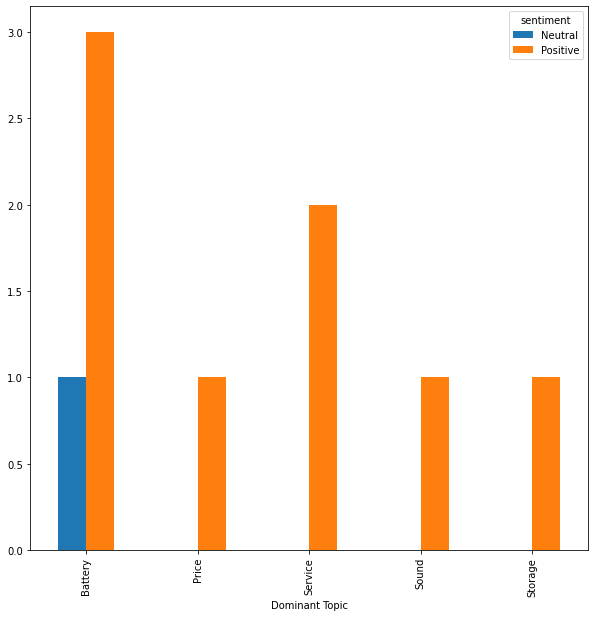

In [ ]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in reviews_filtered['Dominant Topic'].unique():
    
    if i == 1:
        tmp_1 = reviews_filtered.loc[reviews_filtered['Dominant Topic'] == i]
            
        for j in tmp_1['tokenise'].values.tolist():
          
          for p in nltk.pos_tag(j):
              get_pos_tag = get_wordnet_pos(p[1])
              if type(get_pos_tag) == str:
                  try:        
                      synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                      if synset.obj_score() <= 0.49:
                          if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                  positive_words.append(p[0])
                          elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                  negative_words.append(p[0])      
                  except:
                      pass
      

In [ ]:
unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

print(positive_words)

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

[]


In [ ]:
positive_words.head()

,word,score


In [ ]:
# co = 0
# 
# for lists in reviews_filtered['Sentence Topics']:
#   for li in lists:
#       while co <= len(li):
#         if l > 0.0:
#           li[co] = topics[co]

# print(li)

#     # lambda x: l for l in li for li in lists if l
#     # reviews_filtered['Sentence Topics'].map(1.0 if lfor l in li for li in x if l > 0.0 )
#     #4 if x==1 else x for x in a]

# reviews_filtered['opics'] = reviews_filtered['Sentence Topics'].apply(lambda x: [1.0 if l > 0.0 else l for l in li for li in lists] )
      

In [ ]:
# data = list(jumia_df.reviewText)

In [ ]:
# bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
# trigram = gensim.models.Phrases(bigram[data], threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# nltk.download('stopwords')

In [ ]:
# # only need tagger, no need for parser and named entity recognizer, for faster implementation
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# # get stopwords from nltk library
# stop_words = nltk.corpus.stopwords.words('english')

# def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
#     """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
#     # remove stopwords, short tokens and letter accents 
#     texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
#     # bi-gram and tri-gram implementation
#     texts = [bigram_mod[doc] for doc in texts]
#     texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
#     texts_out = []
    
#     # implement lemmatization and filter out unwanted part of speech tags
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
#     # remove stopwords and short tokens again after lemmatization
#     texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
#     return texts_out

In [ ]:
# data_ready = process_words(data)
# data_ready

In [ ]:
# id2word = corpora.Dictionary(data_ready)
# print('Total Vocabulary Size:', len(id2word))

In [ ]:
# corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# dict_corpus = {}

# for i in range(len(corpus)):
#   for idx, freq in corpus[i]:
#     if id2word[idx] in dict_corpus:
#       dict_corpus[id2word[idx]] += freq
#     else:
#        dict_corpus[id2word[idx]] = freq
       
# dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
# dict_df.sort_values('freq', ascending=False).head(10)

In [ ]:
# extension = dict_df[dict_df.freq>1500].index.tolist()

In [ ]:
# ids=[id2word.token2id[extension[i]] for i in range(len(extension))]
# id2word.filter_tokens(bad_ids=ids)

In [ ]:
# # add high frequency words to stop words list
# stop_words.extend(extension)# rerun the process_words function
# data_ready = process_words(data)# recreate Dictionary
# id2word = corpora.Dictionary(data_ready)
# print('Total Vocabulary Size:', len(id2word))

In [ ]:
# # Filter out words that occur less than 10 documents, or more than
# # 50% of the documents.id2word.filter_extremes(no_below=10, no_above=0.5)
# print('Total Vocabulary Size:', len(id2word))

In [ ]:
# # Create Corpus: Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in data_ready]
# id2word